In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import fitsio
import desimodel.io
import desitarget.mtl
import desisim.quickcat
from astropy.io import fits
from astropy.table import Table, Column, vstack
import json
import shutil
import healpy


from desitarget.targetmask import desi_mask, obsconditions
from collections import Counter
import subprocess

%matplotlib inline

# Global statistics

In [3]:
def consolidate_favail(fba_files):
    # getting all the targetids of the assigned fibers
    print('reading individual fiberassign files')
    favail = list()
    for i_tile, tile_file in enumerate(fba_files):
        if i_tile%50 ==0:
            print(i_tile)
        id_favail, header = fits.getdata(tile_file, 'FAVAIL', header=True)
        favail.extend(id_favail['TARGETID'])
    return list(set(favail))

def global_efficiency(targets, id_avail, zcat, target_class='QSO', zcat_spectype='QSO', z_max=None, z_min=None):
    ii_avail = np.in1d(targets['TARGETID'], id_avail)
    targets_avail = targets[ii_avail]

    if z_max is None and z_min is None:
        sub_zcat = zcat.copy()
    elif (z_min is not None) or (z_max is not None):
        if z_max is not None:
            sub_zcat = zcat[zcat['Z']<z_max]
        if z_min is not None:
            sub_zcat = zcat[zcat['Z']>z_min]
    else:
        print("Error")
        sub_zcat = None

    # input target consistent with target_class
    is_class = (targets_avail['DESI_TARGET'] & desi_mask.mask(target_class))!=0
    targets_avail_class = targets_avail[is_class]
    n_avail = len(targets_avail_class)

    # output in the redshift catalog consistent with truth_spectype
    sub_zcat_class = sub_zcat[sub_zcat['SPECTYPE']==zcat_spectype]
    
    # keep the elements in the zcat that correspond to the correct input target class
    id_intersection = np.in1d(sub_zcat_class['TARGETID'], targets_avail_class['TARGETID'])
    sub_zcat_class = sub_zcat_class[id_intersection]
    n_assigned = len(sub_zcat_class)

    nobs = dict()
    for i in range(10):
        nobs[i] = np.count_nonzero(sub_zcat_class['NUMOBS']==i)
    nobs[0] = (n_avail - n_assigned)

    print(target_class, zcat_spectype, n_assigned/n_avail, n_avail, n_assigned, nobs)
    
def tile_efficiency(qa_json_file):
    f = open(qa_json_file)
    qa_dict = json.load(f)
    f.close()
    assign_total = []
    assign_science= []
    assign_sky = []
    assign_std = []
    for k in qa_dict:
        assign_total.append(qa_dict[k]['assign_total'])
        assign_science.append(qa_dict[k]['assign_science'])
        assign_sky.append(qa_dict[k]['assign_sky'])
        assign_std.append(qa_dict[k]['assign_std'])
    assign_total = np.array(assign_total)
    assign_science = np.array(assign_science)
    assign_sky = np.array(assign_sky)
    assign_std = np.array(assign_std)
    n_not_enough_sky = np.count_nonzero(assign_sky<400)
    n_not_enough_std = np.count_nonzero(assign_std<100)
    f_unassigned = (5000 - assign_total)/5000
    print(n_not_enough_sky, n_not_enough_std, np.median(f_unassigned))

In [9]:
workdir = os.path.join(os.getenv('SCRATCH'), 'multipass')
os.chdir(workdir)

In [10]:
pwd

'/global/cscratch1/sd/forero/multipass'

In [13]:
! mkdir strategy_A/fiberassign_full
! cp strategy_A/fiberassign_dark0/fiberassign*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_dark1/fiberassign*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_dark2_dark3/fiberassign*.fits strategy_A/fiberassign_full/
! cp strategy_A/fiberassign_gray/fiberassign*.fits strategy_A/fiberassign_full/
! fba_run_qa --dir strategy_A/fiberassign_full/ --prefix fiberassign-

mkdir: cannot create directory ‘strategy_A/fiberassign_full’: File exists
INFO: Loaded focalplane for time stamp 2020-01-27 14:39:40.938153
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Found 1600 fiberassign tile files
INFO: Selecting 1600 fiberassign tile files
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 3800
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 14635
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 28441
INFO: Processing tile 22694
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 28518
INFO: Processing tile 11145
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 7838
INFO: Processing tile 11163
INFO: Processing tile 9561
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 13631
INFO: Process

In [15]:
fba_files_A = glob.glob('strategy_A/fiberassign_full/fiberassign-*fits')
favail_A = consolidate_favail(fba_files_A)
zcat_A = Table.read('strategy_A/zcat/dark2_dark3_zcat.fits')
tile_efficiency('strategy_A/fiberassign_full/qa.json')
targets = Table.read("targets/subset_dr8_mtl_dark_gray_NGC.fits")
truth = Table.read("targets/subset_truth_dr8_mtl_dark_gray_NGC.fits")
targets.sort(keys='TARGETID')
zcat_A.sort(keys='TARGETID')
truth.sort(keys='TARGETID')


reading individual fiberassign files
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
61 88 0.0


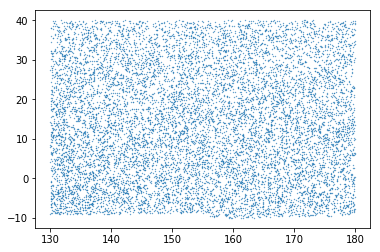

In [16]:
n_targets = len(targets)
r = np.random.random(n_targets)
rr = r<0.001
plt.scatter(targets['RA'][rr], targets['DEC'][rr], s=0.1)

In [17]:
ii = (targets['RA']>140.0) & (targets['RA']<180.0) & (targets['DEC']>10.0) & (targets['DEC']<20)
small_targets = targets[ii]

In [18]:
global_efficiency(small_targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO')
global_efficiency(small_targets, favail_A, zcat_A, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_A, zcat_A, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(small_targets, favail_A, zcat_A, target_class='QSO', zcat_spectype='QSO', z_max=2.15)

QSO QSO 0.984760415708636 108730 107073 {0: 1657, 1: 78412, 2: 11455, 3: 4792, 4: 12414, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.9438226798409703 187638 177097 {0: 10541, 1: 133910, 2: 43187, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.6988616388637185 1009785 705700 {0: 304085, 1: 705700, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.1733468224041203 108730 18848 {0: 89882, 1: 501, 2: 1556, 3: 4403, 4: 12388, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.8114135933045158 108730 88225 {0: 20505, 1: 77911, 2: 9899, 3: 389, 4: 26, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [21]:
! mkdir strategy_B/fiberassign_full
! cp strategy_B/fiberassign_dark0/fiberassign*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_dark1/fiberassign*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_dark2_dark3/fiberassign*.fits strategy_B/fiberassign_full/
! cp strategy_B/fiberassign_gray/fiberassign*.fits strategy_B/fiberassign_full/
! fba_run_qa --dir strategy_B/fiberassign_full/ --prefix fiberassign-

mkdir: cannot create directory ‘strategy_B/fiberassign_full’: File exists
INFO: Loaded focalplane for time stamp 2020-01-27 19:00:57.257528
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Found 1600 fiberassign tile files
INFO: Selecting 1600 fiberassign tile files
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 3800
INFO: Processing tile 28441
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 7838
INFO: Processing tile 14635
INFO: Processing tile 5376
INFO: Processing tile 28518
INFO: Processing tile 24911
INFO: Processing tile 13631
INFO: Processing tile 22718
INFO: Focalplane has 0 fibers that are stuck / broken
INFO: Processing tile 16895
INFO: Processing tile 16977
INFO: Processing tile 22694
INFO: Processing tile 7820
INFO: Processing tile 8720
INFO: Processing tile 11163
INFO: Processing tile 24157
INFO: Pro

In [24]:
fba_files_B = glob.glob('strategy_B/fiberassign_full/fiberassign-*fits')
favail_B = consolidate_favail(fba_files_B)
zcat_B = Table.read('strategy_B/zcat/dark2_dark3_zcat.fits')
#tile_efficiency('strategy_B/fiberassign_full/qa.json')
targets.sort(keys='TARGETID')
zcat_B.sort(keys='TARGETID')
truth.sort(keys='TARGETID')

reading individual fiberassign files
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550


In [25]:
global_efficiency(small_targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO')
global_efficiency(small_targets, favail_B, zcat_B, target_class='LRG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_B, zcat_B, target_class='ELG', zcat_spectype='GALAXY')
global_efficiency(small_targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO', z_min=2.15)
global_efficiency(small_targets, favail_B, zcat_B, target_class='QSO', zcat_spectype='QSO', z_max=2.15)

QSO QSO 0.9847696128023544 108730 107074 {0: 1656, 1: 78552, 2: 11312, 3: 4789, 4: 12421, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
LRG GALAXY 0.9437214210341189 187638 177078 {0: 10560, 1: 133912, 2: 43166, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
ELG GALAXY 0.7068455166198745 1009785 713762 {0: 296023, 1: 713762, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.17333762531040192 108730 18847 {0: 89883, 1: 498, 2: 1557, 3: 4406, 4: 12386, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
QSO QSO 0.8114319874919526 108730 88227 {0: 20503, 1: 78054, 2: 9755, 3: 383, 4: 35, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
